In [1]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from smr import File
import numpy as np
from matplotlib import pyplot as plt
from kaveh.behavioral import oculomotor
from kaveh import plots

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [68]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091208/B091208_1554_Adapt.smr'
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)


In [69]:
chan_titles = [chan.title for chan in smr_content.channels]
for i, ct in enumerate(chan_titles):
    print("{}: {}".format(i, ct))

0: Unit
1: HE
2: VE
3: HT
4: VT
5: H2 Targ
6: V2 Targ
7: Aux 1
8: Aux 2
9: Saved Eve
10: Saccade O
11: Saccade E
12: Burst Ons
13: Burst End
14: Target Ti
15: Spike
16: Spike Den
17: Accept Sp
18: Raster
19: Keyboard
20: Events


<IPython.core.display.Javascript object>


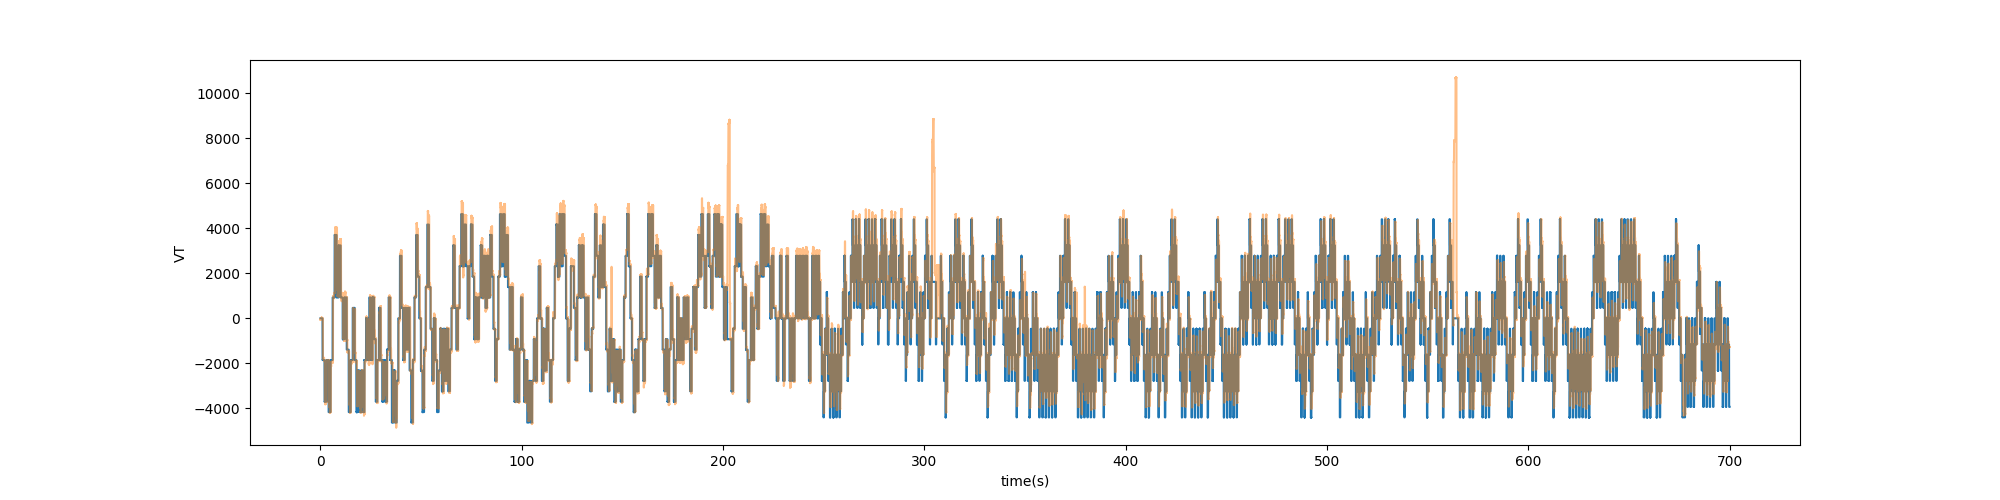

<IPython.core.display.Javascript object>


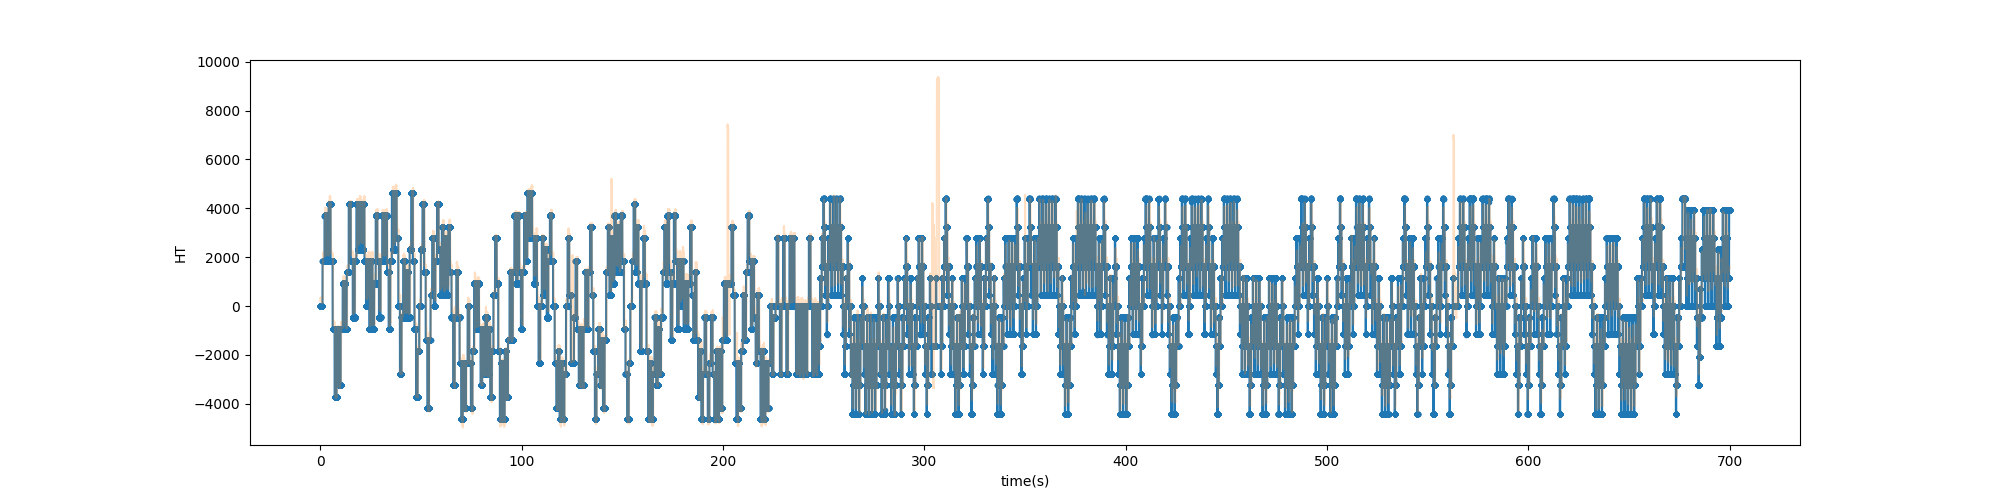

Text(0.5,0,u'time(s)')

In [70]:
vt = smr_content.get_channel(4)
ve = smr_content.get_channel(2)

ht = smr_content.get_channel(3)
he = smr_content.get_channel(1)

t_range = (0,700) #s
fsize =  (20,5)
i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange]/float(2*vt.divide))
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange]/float(2*ve.divide), alpha=0.5)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange])
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange], alpha=0.5)
plt.ylabel(vt.title)
plt.xlabel('time(s)')

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange]/float(2*ht.divide),'.-')
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange]/float(2*ht.divide), alpha=0.25)

plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange],'.-')
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange], alpha=0.25)

plt.ylabel(ht.title)
plt.xlabel('time(s)')


<IPython.core.display.Javascript object>


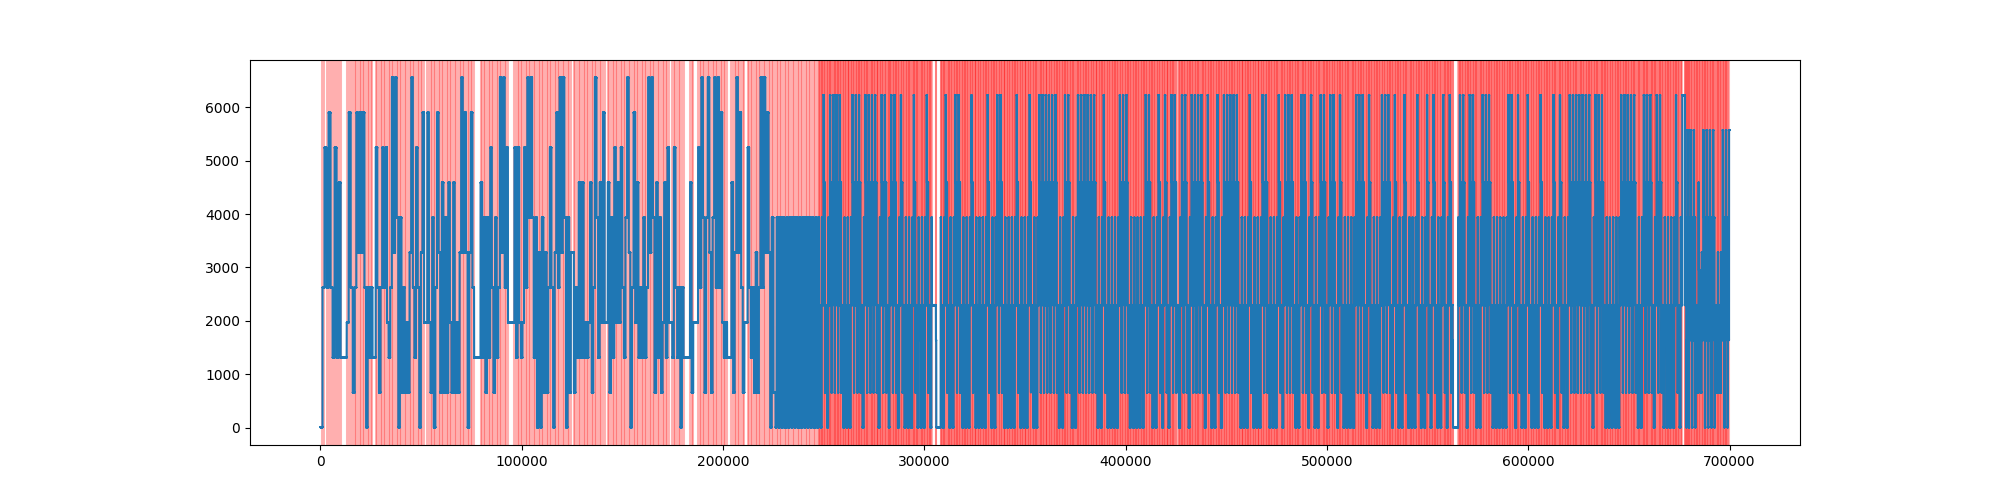

In [71]:
pos_2d = np.column_stack((vt.data[prange], ht.data[prange]))
pos_norm = np.linalg.norm(pos_2d, axis = -1)
plt.figure(figsize=fsize)
plt.plot(pos_norm)

In [72]:
import scipy.signal
# plt.figure()
# plt.plot(ht.data[prange],'.-')

# find target jumps
pos_diff = np.abs(np.diff(pos_norm))
target_jump_indices = scipy.signal.find_peaks(pos_diff, prominence=200)[0]


# remove detected target jumps that are sequential (less than 5 samples apart)
to_delete = []
for i, tji in enumerate(target_jump_indices[1:]):
    if tji - target_jump_indices[i] < 5:
        to_delete = to_delete + [i+1]
        print(i)
mask = np.ones(target_jump_indices.shape, dtype=bool)
mask[to_delete] = False
target_jump_indices = target_jump_indices[mask]

from kaveh.plots import axvlines
axvlines(plt.gca(), target_jump_indices, color='r', alpha=0.3 )


In [73]:
jump_vecs_h = []
for tji in target_jump_indices:
    jump_vecs_h = jump_vecs_h + [ht.data[prange][tji + 5] - ht.data[prange][tji - 5]]
jump_vecs_h = np.array(jump_vecs_h)    
    
jump_vecs_v = []
for tji in target_jump_indices:
    jump_vecs_v = jump_vecs_v + [vt.data[prange][tji + 5] - vt.data[prange][tji - 5]]
jump_vecs_v = np.array(jump_vecs_v)

In [ ]:
plt.figure()
plt.hist(jump_vecs_h)

In [74]:
jump_vecs = np.column_stack((jump_vecs_h, jump_vecs_v))


In [75]:
from sklearn.cluster import KMeans
#jump_vecs = np.array(jump_vecs).reshape(-1,1)
kmeans = KMeans(n_clusters=16, random_state=0).fit(jump_vecs)
jump_amps = kmeans.cluster_centers_
#jump_amps = np.array([int(ja) for ja in jump_amps])

In [55]:
jump_amps.shape

(16, 2)

<IPython.core.display.Javascript object>


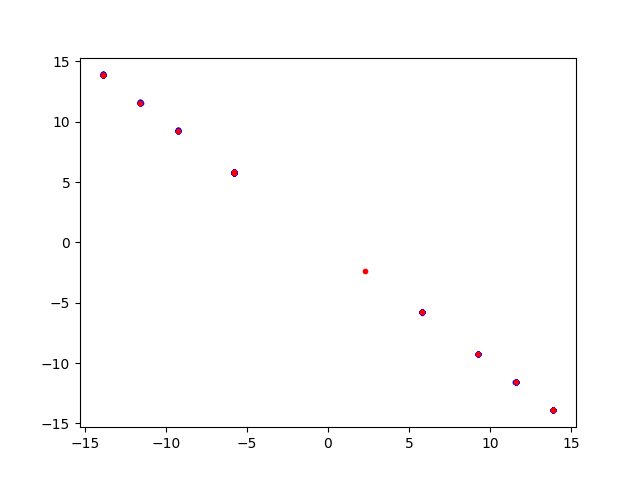

In [76]:
plt.figure()
plt.plot(jump_vecs_h/(ht.l_chan_dvd*ht.scale/10.0), jump_vecs_v/(vt.l_chan_dvd*vt.scale/10.0), '.b', alpha = 0.4)
plt.plot(jump_amps[:,0]/(ht.l_chan_dvd*ht.scale/10.0), jump_amps[:,1]/(vt.l_chan_dvd*vt.scale/10.0), '.r', alpha=1)

<IPython.core.display.Javascript object>


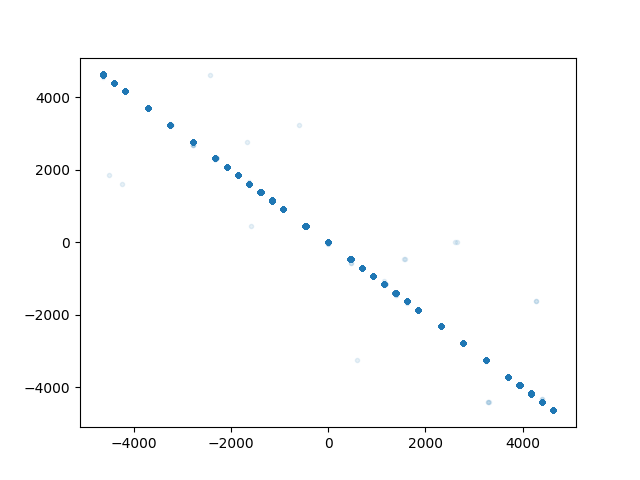

In [77]:
plt.figure()
# plt.plot(ht.data[prange]/(ht.l_chan_dvd*ht.scale/10.0), vt.data[prange]/(vt.l_chan_dvd*vt.scale/10.0), '.', alpha=0.1)
plt.plot(ht.data[prange], vt.data[prange], '.', alpha=0.1)

<IPython.core.display.Javascript object>


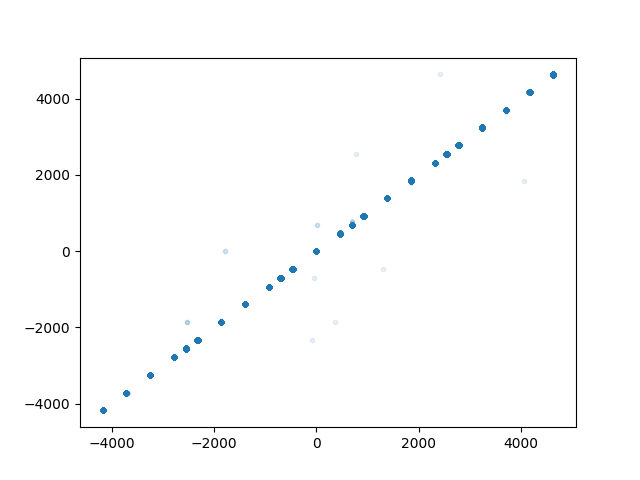

In [57]:
plt.figure()
# plt.plot(ht.data[prange]/(ht.l_chan_dvd*ht.scale/10.0), vt.data[prange]/(vt.l_chan_dvd*vt.scale/10.0), '.', alpha=0.1)
plt.plot(ht.data[prange], vt.data[prange], '.', alpha=0.1)

In [ ]:
%matplotlib inline
import time
# import pylab as pl
from IPython import display
plt.figure(figsize=(10,10))

for i in range(i_range[0], i_range[1], 10):
    plt.plot(ht.data[i],vt.data[i], 'or')
    plt.ylim((-5000,5000))
    plt.xlim((-5000,5000))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.001)
    plt.cla()
#     plt.cla()